## _TABLE OF CONTENTS_
* __1.0 OVERVIEW__
* 1.1 Dataset Description
* __2.0 DATA PREPARATION__
* 2.1 Duplicate Check
* 2.2 Missing Value Check
* 2.3 Checking for Missing Value Placeholder
* __3.0 DESCRIPTION OF CATEGORICAL DATA__
* 3.1 Gender
* 3.2 Geography
* 3.3 HasCrCard
* 3.4 IsActiveMember
* 3.5 Exited
* __4.0 CREATING FEATURE MATRIX X AND PREDICTION TARGET Y__
* __5.0 STATISTICAL DESCRIPTION OF NUMERICAL ATTRIBUTES__
* 5.1 CreditScore
* 5.2 Age
* 5.3 Tenure
* 5.4 Balance
* 5.5 NumOfProducts
* 5.6 EstimatedSalary
* 5.7 Numerical Attributes Distribution Plots
* __6.0 FEATURE SELECTION__
* 6.1 Creating a Test Set
* 6.2 Mutual Information Scoring
* 6.3 Correlation Matrix
* 6.4 Categorical Plots
* 6.5 Creating Feature Matrix
* __7.0 MODEL BUILDING__
* 7.1 Numerical Preprocessing
* 7.2 Categorical Preprocessing
* 7.3 Combined Preprocessor
* 7.4 Model Pipeline
* 7.5 Cross Validation
* 7.6 Pruning
* _7.6.1 Optimal Effective Alpha_
* _7.6.2 Visualising Training and Validation Accuracy_
* _7.6.3 Pruned Decision Tree_
* 7.7 Random Forest Classifier
* _7.7.1 Optimising Random Forest_
* _7.7.2 Class Weights_
* __8.0 FITTING FINAL MODELS__
* 8.1 Baseline Model
* 8.2 Weighted Model
* __9.0 TESTING MODELS__
* 9.1 Baseline Model
* _9.1.1 Results_
* _9.1.2 Metrics and Confusion Matrix Plots_
* 9.2 Weighted Model
* _9.2.1 Results_
* _9.2.2 Metrics and Consusion Matrix Plots_
* __10.0 CONCLUSION__

In [81]:
#  Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## 1. 0 Overview
The purpose of this project is to build a classification model capable of predicting if a particular customer is likely to maintain his/her account with a bank or terminate said account based on certain attributes about the customer in question.

Tree based algorithms will be used for model buiilding starting with a Decision Tree Classifier which will be optimised by pruning afterwhich a Random Forest Classifier will be instantiated which will utilize the advantages of using an ensemble of the pruned Decision Trees. The Random Forest Classifier will be optimised by tuning the n_estimators hyperparameter.

In [82]:
#  Reading dataset into memory
filepath = 'C:/Users/ORE/JupyterNotebook/Datasets/churn_modelling.csv'

customer_data = pd.read_csv(filepath, index_col = 'RowNumber')

customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


### 1.1 Dataset Description
The dataset for this project was sourced from [kaggle.com](https://www.kaggle.com/shrutimechlearn/churn-modelling). The dataset contains information about 10,000 instances (customers, in this case) across 13 different attributes ranging from customer ID to credit score and so on.

#### Definition of Attributes
    1) CustomerId - A numerical identification unique to each customer.
    2) Surname - Customer's surname.
    3) CreditScore - A number ranging between 300-850 which measures how suitable a customer is for a loan/credit. The highe-r the score the more confident lenders will be that a loan will be repayed.
    4) Geography - The geographical location of a customer. In this case, a customer's country of residence.
    5) Gender - Customer's gender.
    6) Tenure - How long a given customer's account has been held with the bank.
    7) Balance - Bank account balance in euros.
    8) NumOfProduct - Number of bank products/services being used by customer.
    9) HasCrCard - Whether customer possesses a credit card. (Yes=1, No=0).
    10) IsActiveMember - Whether customer actively uses bank account. (Yes=1, No=0).
    11) EstimatedSalary - Customer's estimated salary in euros.
    12) Exited - Whether account was closed. (Yes=1, No=0)
    

A number of attributes are categorical in nature, they are; Surname, Gender, Geography, HasCrCard, IsActiveMember and Exited. While HasCrCard, IsActiveMember and Exited have all been encoded with numerical values for Yes/No, Surname, Gender and Geography are left in their string forms. 

In [83]:
#  Displaying preview
customer_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2.0 Data Preparation
Data preparation took place in 3 steps;
    
    1) Duplicate check.
    2) Missing value check.
    3) Checking for missing value placeholders.
    
### 2.1 Duplicate Check

In [84]:
#  Checking dataset for duplicates
if customer_data.duplicated().sum() > 0:
    print(f'There are/is duplicates in this dataset\nNumber: {customer_data.duplicated().sum()}')
else:
    print('Dataset contains no duplicates')

Dataset contains no duplicates


### 2.2 Missing Value Check

In [85]:
#  Checking for missing values
if customer_data.isnull().sum().sum() > 0:
    print(f'There are/is {customer_data.isnull().sum().sum()} missing values in this dataset')
else:
    print('There are no missing values in this dataset')

There are no missing values in this dataset


### 2.3 Checking for Missing Value Placeholders
Some datasets have missing values filled in with a numerical placeholder which is usually '0'. To check for this I am going to look through certain columns where its impossible to have a value of zero such as 'Surname', 'Geography', 'Gender' and 'Age'.

In [86]:
#  Checking if '0' has been used as sentinel for missing values
(customer_data[['Surname', 'Geography', 'Gender', 'Age']] == 0).sum()

Surname      0
Geography    0
Gender       0
Age          0
dtype: int64

None of these attributes have values equal to zero, therefore there are no missing value placeholders in the dataset

##  3.0 Description of Categorical Data

### 3.1 Gender
From the analysis below, it is seen that 54.57\% of customers (5,457) are Male while the other 45.43\% (4,543) are female. It can also be seen that at a value of just over 1000, more women terminated their accounts with the bank compared to men which stood at just under 1000.

In [87]:
#  Proportion by gender
customer_data.Gender.value_counts(normalize=True)

Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

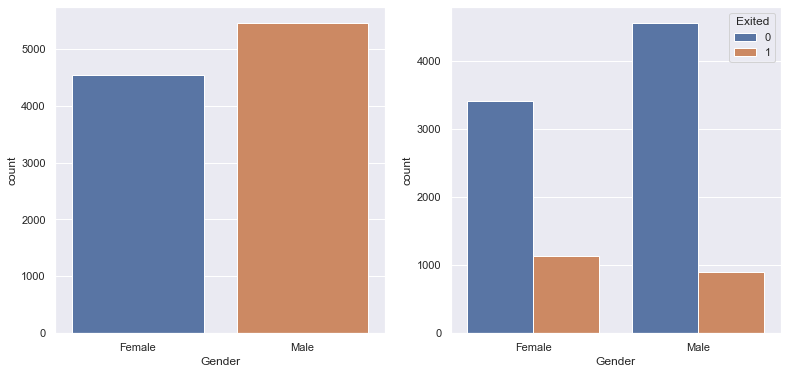

In [88]:
#  Defining plot function
def count_plot(attribute):
    """This function plots barplots of an argument supplied. One without a hue and the other with Exited as hue"""
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))
    sns.countplot(x=attribute, data=customer_data, ax=axes[0])
    sns.countplot(x=attribute, data=customer_data, hue='Exited', ax=axes[1])
    
count_plot('Gender')

### 3.2 Geography
Across customers, 5014 (50.14\%) are domiciled in France while 2509 (25\%) and 2477 (24.77\%) live in Germany and Spain respectively. Identical number of customers terminated their accounts in France and Germany at a count of approximately 800 while Spainish residents terminated their accounts at a significantly lower count, just under 500.

In [89]:
#  Proportion by geography
customer_data.Geography.value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

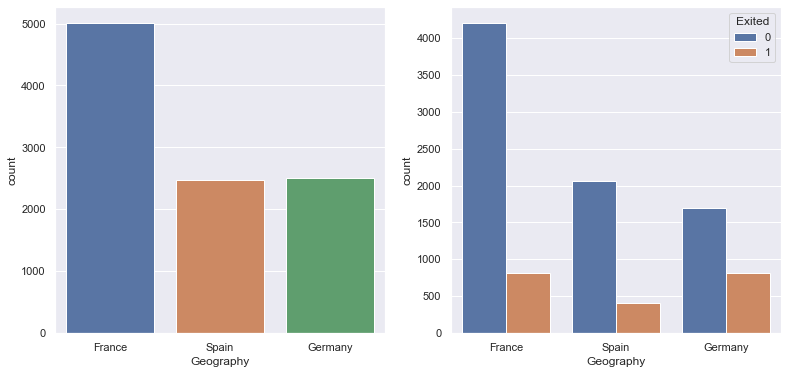

In [90]:
count_plot('Geography')

### 3.3 HasCrCard
70.5\% of all customers possess a credit card, while 29.4\% do not. More people who hold credit cards terminated their accounts, a trend which is expected since the proportion of customers with credit cards is markedly higher. 

In [91]:
#  Proportion by credit card
customer_data.HasCrCard.value_counts(normalize=True)

1    0.7055
0    0.2945
Name: HasCrCard, dtype: float64

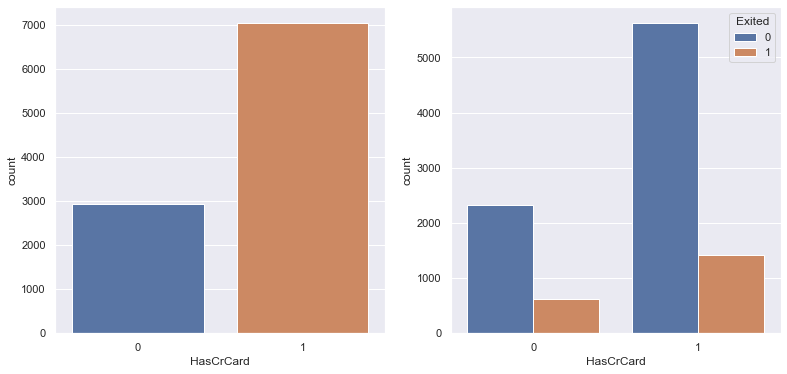

In [92]:
count_plot('HasCrCard')

### 3.4 IsActiveMember
5,151 accounts are active while another 4,849 are inactive. As expected, at approximately 1300 accounts, inactive accounts ended up being terminated at a higher rate compared to active accounts with number of terminations amounting to 800 accounts.

In [93]:
#  Proportion by activeness
customer_data.IsActiveMember.value_counts(normalize=True)

1    0.5151
0    0.4849
Name: IsActiveMember, dtype: float64

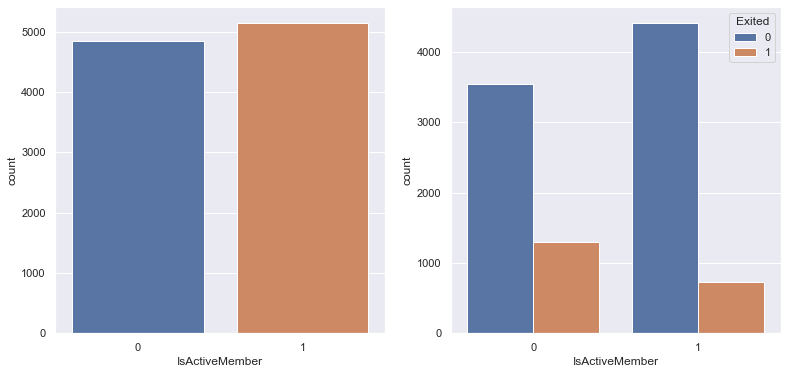

In [94]:
count_plot('IsActiveMember')

### 3.5 Exited
Of the 10,000 accounts in the dataset, only a minority of them ended up being closed at just 2,037, representing 20\% of the entire dataset. 79\% (7,963) of customers retained their accounts with the bank.

In [95]:
#  Proportion by class
customer_data.Exited.value_counts(normalize=True)
#  There is a huge class imbalance therefore tree based algorithms shall be used for model building

0    0.7963
1    0.2037
Name: Exited, dtype: float64

<Figure size 540x360 with 0 Axes>

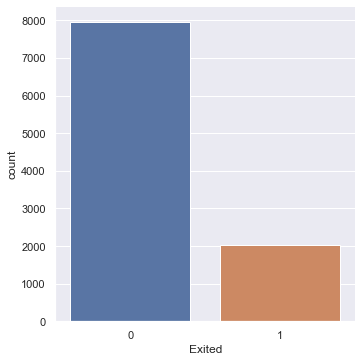

In [96]:
plt.figure(dpi=90)
sns.catplot(x='Exited', data=customer_data, kind='count')

## 4.0 Creating Feature Matrix X and Prediction Traget y.
Upon examining the attributes, attributes such as CustomerId and Surname will have no bearing or influence on a customer's account status, so they will not be treated as potential features.

Below, I have created a matrix of potential features, containing all attributes except CustomerId, Surname (for reasons stated above) and Exited. The column Exited contains class labels and is appropriately selected as the prediction target.

In [97]:
#  Columns CustomerID and Surname are not of interest and will be excluded from feature selection.
X_all = customer_data.loc[:, 'CreditScore':'EstimatedSalary'].copy()
y_all = customer_data.Exited

## 5.0 Statistical Description of Numerical Attributes
Attributes which contain numerical data and are of interest to model building are described in this section.

In [98]:
#  Statistical description of numerical columns.
X_all[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


### 5.1 CreditScore
The minimum credit score across instances is 350 while the maximum is significantly higher at 850 (the maximum credit score possible). The vast majority of customers (75\%) have a credit rating of over 584, while 25\% of customers have a credit score greater than 718. Therefore it can be infered that a majority of customers have good credit rating.

### 5.2 Age
The average age of all customers stands at approximately 39, with 75\% of coustomers falling under the age of 44 and only 25\% being under the age of 32, the majority of customers fall between the age bracket of 32 and 44. The youngest customer on record is 18yrs old while the oldest is 92.

### 5.3 Tenure
On average, most customers have held their  accounts for 5yrs. 25\% of them have held their accounts for at least 6yrs while 25\% have held their accounts for less than 3yrs. This indicates that a majority of the customers have been banking with said bank for a while.

### 5.4 Balance
25\% of customers have no money in their accounts, while another 25\% have atleast 127,000 euros. Average bank balance however stood at around 76,000 euros.

### 5.5 NumOfProducts
Customers use at least one bank product on average with over 50\% of all customers using more than one product and 25\% use more than 2 products. 4 products was the most used by any customer.

### 5.6 EstimatedSalary
The average estimated salary across instances is 100,000 euros, with a minimum of 11.58 euros and a maximum of of approximately 200,000 euros. 25\% of customers earned below 52,000 euros while 75\% earned below 140,000 euros.


### 5.7 Numerical Attributes Distribution Plots
#### Histograms

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Count'>

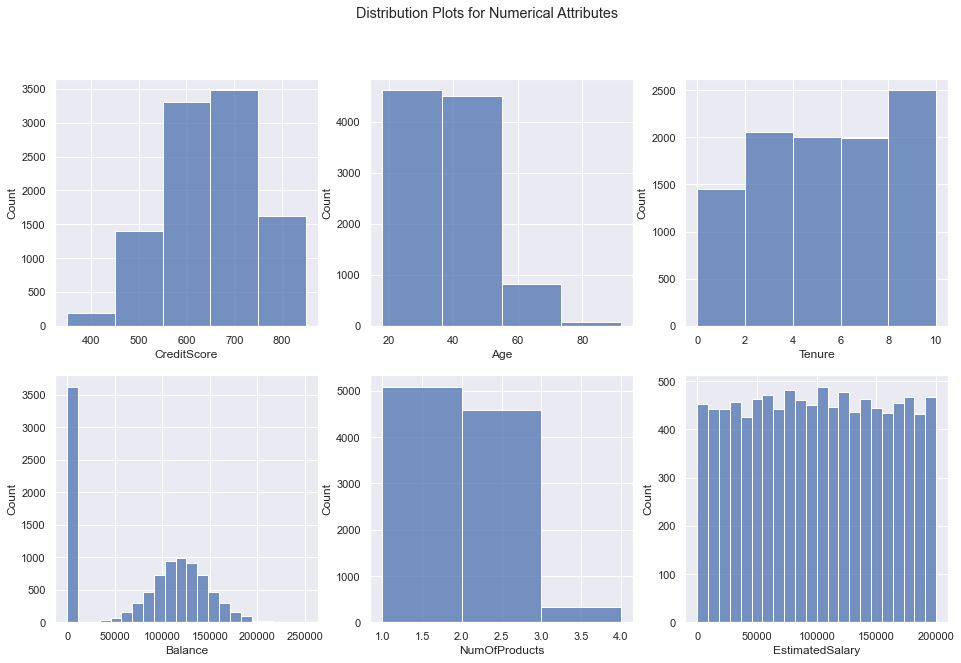

In [99]:
#  Defining histogram plot function
def plot_dist(attribute, i, j, bins='auto'):
    """This function plots histograms of an attribute supplied as an argument"""
    return sns.histplot(x=attribute, data=X_all, kde=False, ax=axes[i,j], bins=bins)

#  Plotting
figure, axes = plt.subplots(2, 3, figsize=(16,10))
plt.suptitle('Distribution Plots for Numerical Attributes')

plot_dist('CreditScore', i=0, j=0, bins=5)
plot_dist('Age', i=0, j=1, bins=4)
plot_dist('Tenure', i=0, j=2, bins=5)
plot_dist('Balance', i=1, j=0)
plot_dist('NumOfProducts', i=1, j=1, bins=3)
plot_dist('EstimatedSalary', i=1, j=2)

#### Kernel Density Plots

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Density'>

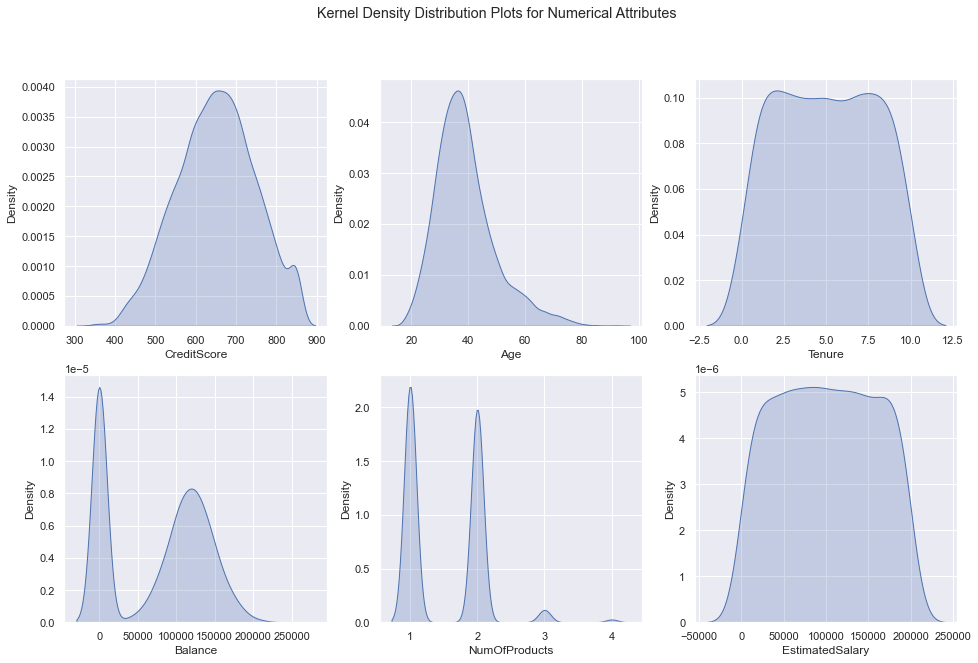

In [181]:
#  Creating kde plot functions
def plot_kde(attribute, i, j, bw_adjust=1):
    """This function plots KDEs of an attribute supplied to it as argument"""
    return sns.kdeplot(x=attribute, data=X_all, shade=True, ax=axes[i,j], bw_adjust=bw_adjust)

#  Plotting
figure, axes = plt.subplots(2, 3, figsize=(16,10))
plt.suptitle('Kernel Density Distribution Plots for Numerical Attributes')

plot_kde('CreditScore', i=0, j=0)
plot_kde('Age', i=0, j=1)
plot_kde('Tenure', i=0, j=2, bw_adjust=1.5)
plot_kde('Balance', i=1, j=0)
plot_kde('NumOfProducts', i=1, j=1)
plot_kde('EstimatedSalary', i=1, j=2, bw_adjust=1.5)

## 6.0 Feature Selection

### 6.1 Creating a Test Set
A test set is created to test the accuracy of the final model. This is different from the validation set which will be used to check for accuracy at some point during model building so as to optimise hyperparameters

In [101]:
#  Creating a testing set 
X, X_test, y, y_test = train_test_split(X_all, y_all, random_state = 0, test_size = 0.1)

### 6.2 Mutual Information Scoring
Mutual information scores are used to check how much of an impact an attribute has on predicting an instance's class. The higher the mutual information score, the more an attribute's impact on classification.

When deriving mutual information scores, categorical attributes need to be ordinally encoded and passed as keyword argument 'discrete features'.

In [102]:
#  Creating a list of categorical column names
cat_cols = [col for col in X.columns if X[col].dtypes == 'object']

#  Creating a list of dicrete feature names
discrete_features = cat_cols + ['HasCrCard', 'IsActiveMember']

#  Creating a pipeline in preparation for Mutual Information Scoring
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#  Creating a copy of X and y for MI scoring
X_mi = X.copy()
y_mi = y.copy()

#  Instantiating OrdinalEncoder
ordinal = OrdinalEncoder(handle_unknown = 'ignore', dtype = 'int32')

#  Encoding categorical data
X_mi[cat_cols] = ordinal.fit_transform(X_mi[cat_cols])

#  Mutual Information scoring
mi_scores = mutual_info_classif(X_mi, y_mi, discrete_features = X_mi[discrete_features])
mi_scores = pd.Series(mi_scores, index = X_mi.columns)
mi_scores = mi_scores.sort_values(ascending = False)
mi_scores

Age                0.074575
NumOfProducts      0.063736
CreditScore        0.030870
Geography          0.013775
IsActiveMember     0.012857
Balance            0.007616
Gender             0.005465
HasCrCard          0.003746
EstimatedSalary    0.003405
Tenure             0.000870
dtype: float64

Text(0.5, 1.0, 'Mutual Information Scores of Potential Model Features')

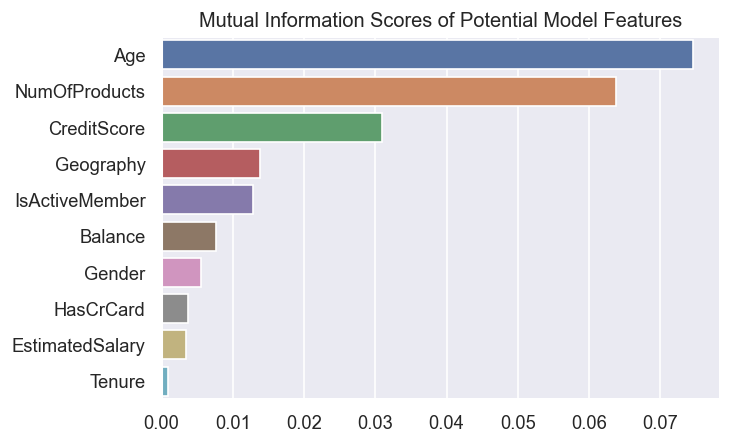

In [103]:
#  Visualising MI scores
plt.figure(dpi=120)
sns.barplot(x = mi_scores.values, y = mi_scores.index)
plt.title('Mutual Information Scores of Potential Model Features')

As seen from the barplot above, the highest mutual information scores were gotten at Age, NumOfProducts and CreditScore. For model building however, the top 5 highest scoring attributes will be selected as model features.

Before discounting attributes with low MI scores, they will be checked against attributes with high MI scores to see if there is any relationship between them. For numerical attributes (Balance, Tenure, EstimatedSalary) a Pearson's Correlation Matrix will be made, allowing for a comparision of correlation. Categorical attributes (Gender) on the other hand will be checked using categorical plots.

### 6.3 Correlation Matrix

In [104]:
#  Creating a correlation matrix
X_mi.corr()[['Balance', 'Tenure', 'EstimatedSalary']]

,Balance,Tenure,EstimatedSalary
CreditScore,0.004388,-0.000854,-0.000100
Geography,0.065470,0.002002,0.001175
Gender,0.016550,0.016198,-0.008466
Age,0.023724,-0.006693,-0.007485
Tenure,-0.005739,1.000000,0.013671
Balance,1.000000,-0.005739,0.007437
NumOfProducts,-0.307007,0.016229,0.015376
HasCrCard,-0.009950,0.019121,-0.008330
IsActiveMember,-0.013598,-0.031500,-0.009677
EstimatedSalary,0.007437,0.013671,1.000000


From the correlation matrix, it is seen that none of the three atrributes show a strong correlation with any of the attributes with high mutual information scores. The best correlation seen was -0.30 between Balance and NumberOfProducts which indicates that customers with high bank balances use less bank products. This is however not significant enough for Balance to be included in model building.

### 6.4 Categorical Plots
#### Gender

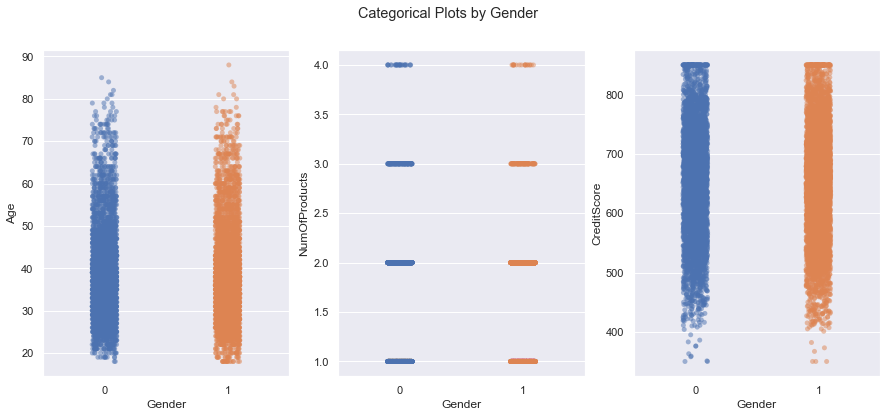

In [105]:
def plot_gender(attribute, i, alpha=1):
    """This function creates categorical plots of a supplied argument against Gender"""
    sns.stripplot(x='Gender', y=attribute, data=X_mi, alpha=alpha, ax=axes[i])

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
plt.suptitle('Categorical Plots by Gender')

plot_gender('Age', i=0, alpha=0.5)
plot_gender('NumOfProducts', i=1, alpha=0.45)
plot_gender('CreditScore', i=2, alpha=0.5)

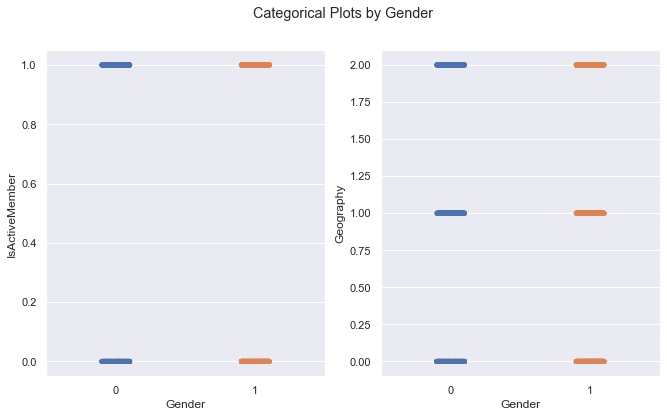

In [106]:
#  Continuation of categorical plots
fig, axes = plt.subplots(1, 2, figsize=(11, 6))
plt.suptitle('Categorical Plots by Gender')

plot_gender('IsActiveMember', i=0, alpha=0.3)
plot_gender('Geography', i=1, alpha=0.3)

#### HasCrCard

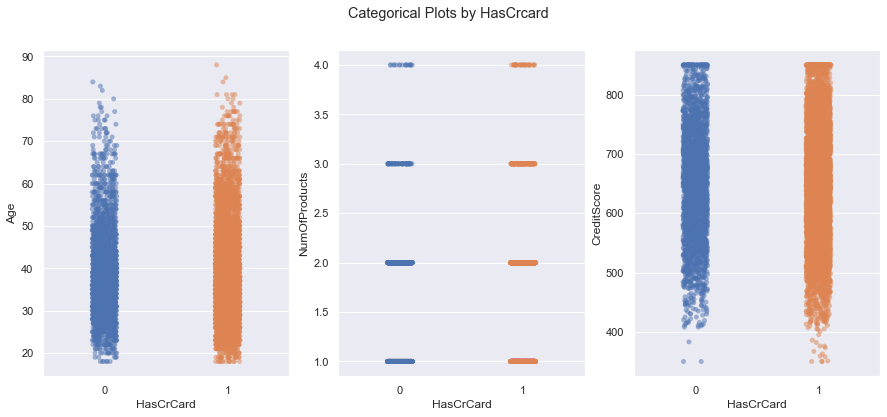

In [176]:
def plot_crcard(attribute, i, alpha=1):
    """This function creates categorical plots of a supplied argument against HasCrCard"""
    sns.stripplot(x='HasCrCard', y=attribute, data=X_mi, alpha=alpha, ax=axes[i])

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
plt.suptitle('Categorical Plots by HasCrcard')

plot_crcard('Age', i=0, alpha=0.5)
plot_crcard('NumOfProducts', i=1, alpha=0.45)
plot_crcard('CreditScore', i=2, alpha=0.5)

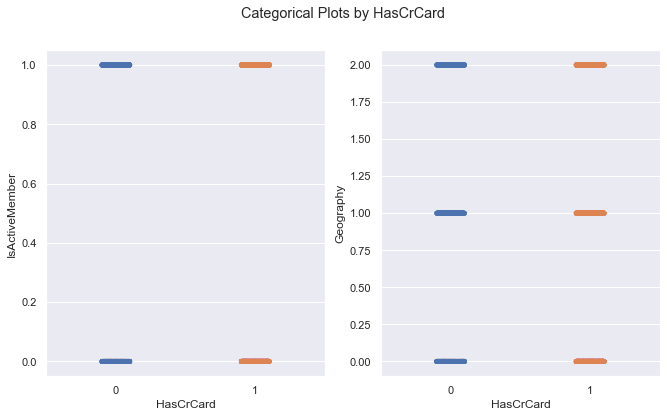

In [177]:
#  Continuation of categorical plots
fig, axes = plt.subplots(1, 2, figsize=(11, 6))
plt.suptitle('Categorical Plots by HasCrCard')

plot_crcard('IsActiveMember', i=0, alpha=0.3)
plot_crcard('Geography', i=1, alpha=0.3)

As seen from the plots above, there seem to be equal distribution of values for both Gender and HasCrCard across attributes which is evident as cluster of points are very similar. Therefore, Gender and HasCrCard will also not be included in model building. 

### 6.5 Creating Feature Matrix
Since none of the low scoring attributes showed any promise, the most important features are those with high MI scores. For this project, the 5 top scoring attributes are deemed high scoring and assigned to variable 'vital_features'.

In [108]:
#  Selected features of interest are:
vital_features = [ind for ind in mi_scores.index[:5]]

#  Reassinging feature matrix X
X = X[vital_features]

#  Spliting in training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 7.0 Model Building
For preprocessing, I have chosen to use a ColumnTransformer since features are a mix of numericals and categoricals which will need to be preprocessed differently. ColumnTransformer helps to bundle the preprocessing steps and apply to necessary columns based on data type.

### 7.1 Numerical Preprocessing
Although there are no missing values in the dataset, there is no guarantee that the further down the line if/when the model is deployed, that the same pattern will hold true. In order to prevent errors if the model encounters a missing value, I have chosen to include an imputation preprocessing step for numerical features. Median values will be used for imputation. This step is assigned to variable 'num_transformer'

### 7.2 Categorical Preprocessing
Categorical preprocessing for this dataset involves two steps which are coupled using a sklearn pipeline. Firstly, imputation using the most frequent value will be done for reasons stated in numerical preprocessing above. Secondly, OneHotEncoding will be done to transform categorical data form string form to numerical form before being feed into the model. These two steps are bundled into one using a sklearn pipeline and assingned to variable 'cat_transformer'.

### 7.3 Combined Preprocessor
Both the numerical and categorical preprocessing steps are then bundled into one in variable 'preprocessor' tied together by ColumnTransformer.

### 7.4 Model Pipeline
A DecisionTreeClassifer is instantiated with default hyperparameters then coupled with the preprocessor using a pipeline and assigned to variable 'pipeline_1'.

In [109]:
from sklearn.impute import SimpleImputer

#  Creating list of categorical and numerical column names in X_train
model_cat_cols = [col for col in X_train.columns if X_train[col].dtypes == 'object']
model_num_cols = [col for col in X_train.columns if X_train[col].dtypes != 'object']

#  Creating transformers
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = SimpleImputer(strategy='median')

#  Creating preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, model_cat_cols),
    ('num', num_transformer, model_num_cols)
])

#  Instantiating model
dt = DecisionTreeClassifier(random_state = 0)

#  Creating preprocessing and modeling pipeline
pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', dt)
])

### 7.5 Cross Validation
The default hyperparameter DecisionTree is cross validated to determine a baseline accuracy score which will help keep track of the optimisation process.

In [179]:
#  Cross Validating DecisionTreeModel
cv_scores = cross_val_score(pipeline_1, X, y, scoring='accuracy')
average_score = cv_scores.mean().round(3)

print(f'Decision Tree Classifier Baseline Score: {average_score*100}%')

Decision Tree Classifier Baseline Score: 78.7%


### 7.6 Pruning
Bear in mind that the baseline Decision Tree is overfitted as all nodes are split till leaf nodes are pure. This is however not desirable as overfitting results in poor validation and testing predictions. Essentially, the model memorises the training data and does poorly when it encounters instances it has never seen before.

There are several hyperparameters which help to prevent overfitting in tree based models such as max_depth, min_samples_split and ccp_alpha. For this project, cost complexity pruning will be used to prevent overfitting, this utilises the ccp_alpha hyperparameter.

Text(0.5, 1.0, 'impurities vs ccp_alpha')

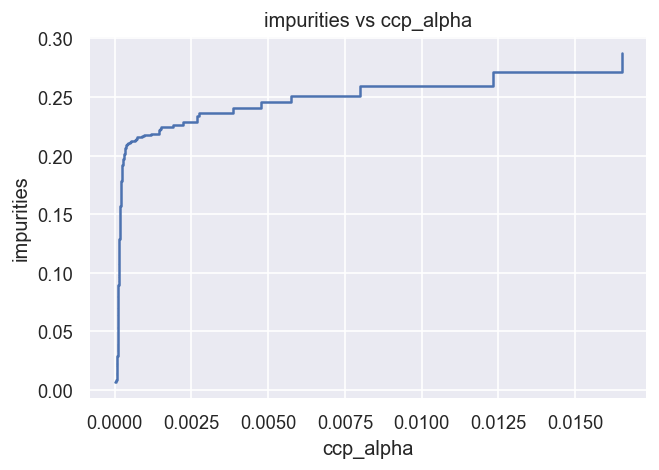

In [111]:
#  Pruning DecisionTree
path = pipeline_1[-1].cost_complexity_pruning_path(pipeline_1[:-1].fit_transform(X_train), y_train)

#  ccp_alphas
ccp_alphas = path.ccp_alphas
#  impurities
impurities = path.impurities

#  Visualising paths
plt.figure(dpi=120)
sns.lineplot(x = ccp_alphas[:-1], y = impurities[:-1], drawstyle = 'steps-post')
plt.xlabel('ccp_alpha')
plt.ylabel('impurities')
plt.title('impurities vs ccp_alpha')

The graph above demonstrates how effective alphas work. At an effective alpha of zero, impurity is also zero, indicating a case of spliting nodes till purity is attained (overfitting). Higher values of effective alphas begin to prevent the tree from attaining full purity, the objective is to find that value of effective alpha that produces the maximum accuracy in the Decision Tree. This is essentially what the pruning process entails.

#### 7.6.1 Optimal Effective Alpha
Here some logic will be used to loop through all effective alphas in variable ccp_alphas, a Decision Tree Classifier will be instantiated with a ccp_alpha hyperparameter. The model will be put into a pipeline to allow for preprocessing before fitting is done. Each effective alpha and the score it produces on validation is then appended to list 'best_pruning'. The list is sorted and the best effective alpha is selected.

In [112]:
#  Finding optimal ccp_alpha
best_pruning = list()

for ccp_alpha in ccp_alphas:
    #  Instantiating model
    dtree = DecisionTreeClassifier(random_state = 0, ccp_alpha=ccp_alpha)
    #  Creating pipeline
    pipeline_2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('dtree', dtree)
    ])
    #  Fitting
    pipeline_2.fit(X_train, y_train)
    #  Appending to list
    best_pruning.append([ccp_alpha, pipeline_2.score(X_val, y_val)])
    
#  Sorting
best_pruning = sorted(best_pruning, key = lambda x: x[1], reverse = True)

#  Obtaining best effective alpha
best_ccp_alpha = best_pruning[0][0]

#### 7.6.2 Visualising Training and Validation Accuracy

In [113]:
#  Creating lists to hold scores
validation_scores = list()
train_scores = list()

#  Looping through effective alphas
for ccp_alpha in ccp_alphas[:-1]:
    #  Instantiating
    dtree_2 = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    #  Pipeline
    pipeline_3 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('dtree_2', dtree_2)
    ])
    #  Fitting
    pipeline_3.fit(X_train, y_train)
    #  Appending to list
    validation_scores.append(pipeline_3.score(X_val, y_val))
    train_scores.append(pipeline_3.score(X_train, y_train))

Text(0.5, 1.0, 'accuracy vs ccp_alpha')

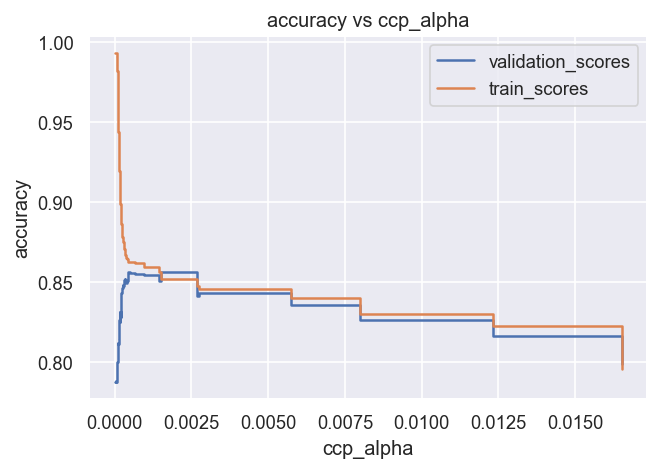

In [114]:
#  Visualisation
plt.figure(dpi=120)
sns.lineplot(x = ccp_alphas[:-1], y = validation_scores, drawstyle = 'steps-post', label = 'validation_scores')
sns.lineplot(x = ccp_alphas[:-1], y = train_scores, drawstyle = 'steps-post', label = 'train_scores')
plt.xlabel('ccp_alpha')
plt.ylabel('accuracy')
plt.title('accuracy vs ccp_alpha')

A plot of accuracy scores for training and validation sets is generated above. At an effective alpha of zero, the training set accuracy is almost 100\% while validation accuracy was below 80\%. this is a classic case of overfitting where there is a large variance between training accuracy and validation accuracy.

As effective alpha increased however, validation scores became optimised at a point between 0 and 0.0025 with a value of just over 85\%. It is also noted that the variance between training accuracy and validation accuracy is much smaller at this value.

In [115]:
#  Optimised effective alpha.
print(f'The optimised value of ccp_alpha: {best_ccp_alpha.round(6)}')

The optimised value of ccp_alpha: 0.00043


#### 7.6.2 Pruned DecisionTree
Optimising the DecisionTreeClassifier with the best value of ccp_alpha yielded a cross validated accuracy score of 85.5\%, up from a baseline score of 78.7\%. 

In [116]:
#  Optimising DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = best_ccp_alpha)

pipeline_5 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', dt)
])

#  Cross validation
dt_optimised_cv = cross_val_score(pipeline_5, X, y, cv=5, scoring='accuracy')

print(f'The optimised DecisionTreeClassifier has an average score of: {dt_optimised_cv.mean().round(3)*100}%')

The optimised DecisionTreeClassifier has an average score of: 85.5%


### 7.7 Random Forest Classifier
To further refine the model, I have elected to take the best_ccp_alpha and use it in creating an ensemble of pruned Decision Trees in a Random Forest model which will then be tuned using its n_estimators hyperparameter.

In [117]:
#  RandomForest
rf = RandomForestClassifier(random_state = 0, ccp_alpha = best_ccp_alpha)

#  Creating pipeline
pipeline_6 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

rf_cv = cross_val_score(pipeline_6, X, y,cv=5, scoring='accuracy')

print(f'RandomForestClassifier has a baseline score of: {rf_cv.mean().round(3)*100}%')

RandomForestClassifier has a baseline score of: 85.7%


#### 7.7.1 Optimising RandomForest

Text(0.5, 1.0, 'accuracy vs number of estimators')

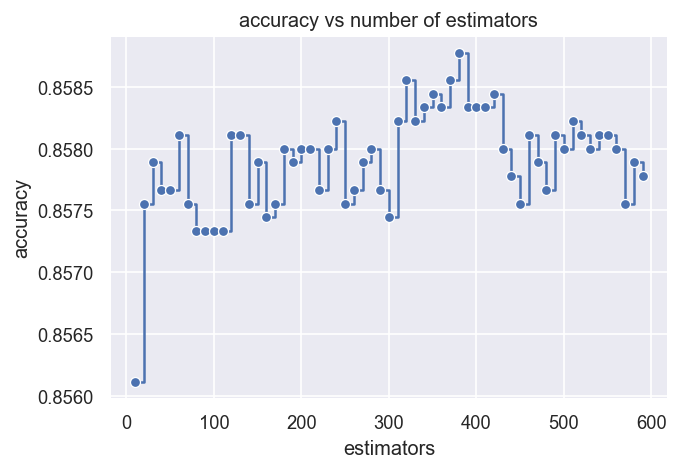

In [118]:
#  LONG RUNTIME***

#  Trying to optimise rf model

#  Defining optimisation function
def optimise_rf(estimator):
    """
    This function takes in a certain value of n_estimators, instantiates a random forest classifier with said value,
    derives cross validation scores and returns the mean of those scores.
    """
    rf_test = RandomForestClassifier(n_estimators = estimator, random_state = 0, ccp_alpha = best_ccp_alpha)
    pipeline_7 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf_test', rf_test)
    ])
    cv_test = cross_val_score(pipeline_7, X, y, cv=5, scoring='accuracy')
    return cv_test.mean()

#  Generating a list of estimators
estimators = np.arange(10, 600, 10)

#  Creating a list to hold scores
rf_accuracy_scores = list()

#  Iterating through lists 
for estimator in estimators:
    rf_accuracy_scores.append(optimise_rf(estimator))
    
#  Visualisation
plt.figure(dpi=120)
sns.lineplot(x = estimators, y = rf_accuracy_scores, marker='o', drawstyle='steps-post')
plt.xlabel('estimators')
plt.ylabel('accuracy')
plt.title('accuracy vs number of estimators')

A n_estimators value of 480 produces the maximum accuracy with a score slightly above 85.8 percent.

In [119]:
#  480 estimators produces the most optimised score
print(f'The optimised RandomForestClassifier has an accuracy score of {round(rf_accuracy_scores[47], 3)*100}%')

The optimised RandomForestClassifier has an accuracy score of 85.8%


#### 7.7.2 Class Weights
Because of the class imbalance in the dataset, i have chosen to handle this by using class weights. Below is a function which will compute recall, precision, f1 and accuracy for a unique combination of class weights.

An array of weights is then passed to the function and outputs appended to list _'weight_scores'_.

In [133]:
###LONG RUNTIME
#  Defining function to find optimal class weight
def get_weight_scores(x):
    """
    This function takes in a certain value for class weight for class label 0, instantiates a model with that value, derives 
    cross validation scores for recall, precision, f1 and accuracy, then returns a list containing the value and its evaluation
    metrics.
    """
    #  Instantiate model
    rf_x = RandomForestClassifier(random_state=0, ccp_alpha=best_ccp_alpha, n_estimators=480, class_weight={0:x, 1:1-x})
    #  Create pipeline
    pipeline_x = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf_x', rf_x)
    ])
    #  Cross validation scores
    recall = cross_val_score(pipeline_x, X, y, cv=4, scoring='recall')
    precision = cross_val_score(pipeline_x, X, y, cv=4, scoring='precision')
    f_1 = cross_val_score(pipeline_x, X, y, cv=4, scoring='f1')
    accuracy = cross_val_score(pipeline_x, X, y, cv=4, scoring='accuracy')
    #  Mean values
    recall = recall.mean()
    precision = precision.mean()
    f_1 = f_1.mean()
    accuracy = accuracy.mean()
    return [x, recall, precision, f_1, accuracy]

#  Creating an array of weights.
weights = np.arange(0, 0.99, 0.01)

#  Creating a list to hold function return values.
weight_scores = list()

#  Looping through weights
for weight in weights:
    weight_scores.append(get_weight_scores(weight))

C:\Users\ORE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ORE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ORE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ORE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-d

Below a plot of all metrics are made against class weight for class 0.

<AxesSubplot:title={'center':'scores vs weight (0)'}, xlabel='weight (0)', ylabel='scores'>

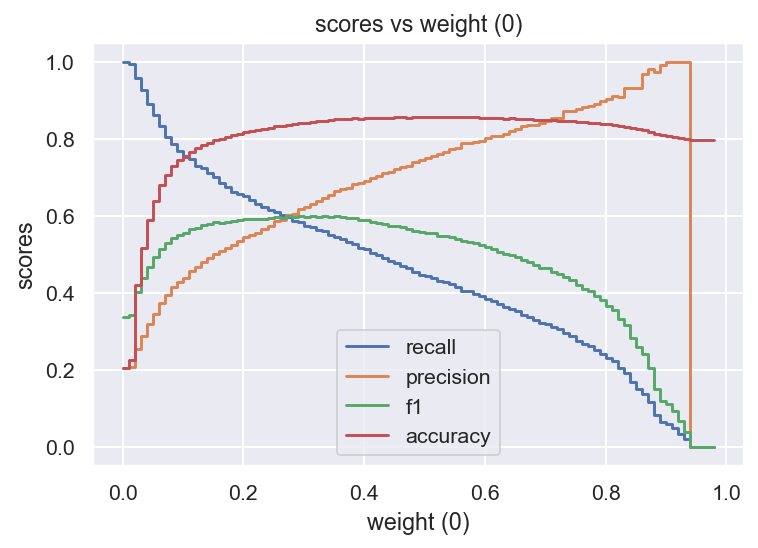

In [173]:
#  Turning nested list into array
weight_scores = np.array(weight_scores)

#  Defining plot function
def plot_lines(array_slice, label):
    """ This function creates line plots of metric scores against class weight (0)"""
    return sns.lineplot(y=array_slice, x=weight_scores[:,0], label=label, drawstyle='steps-post')

#  Plotting
plt.figure(dpi=140)
plt.ylabel('scores')
plt.xlabel('weight (0)')
plt.title('scores vs weight (0)')
plot_lines(weight_scores[:,1], label='recall')
plot_lines(weight_scores[:,2], label='precision')
plot_lines(weight_scores[:,3], label='f1')
plot_lines(weight_scores[:,4], label='accuracy')    

From the graph above, it can be seen that class weights have an impact on all four metrics. Since for this project, the objective is to create a model capable of identifying churn, which is the minority class (1), a model which is adept at identifying positive cases is required. This translates to a model with high recall. For this reason, i will be looking to select class weights which will keep recall at atleast 70\%.

In [147]:
#  Creating DataFrame of scores.
scores_by_weight= pd.DataFrame(weight_scores, columns=['weight (0)', 'recall', 'precision', 'f1', 'accuracy'])
scores_by_weight.head(20)

,weight (0),recall,precision,f1,accuracy
0,0.00,1.000000,0.203444,0.338104,0.203444
1,0.01,0.996174,0.207432,0.343353,0.224667
2,0.02,0.958495,0.254475,0.402133,0.419889
3,0.03,0.926818,0.287291,0.438584,0.517111
4,0.04,0.891862,0.317596,0.468382,0.588111
5,0.05,0.862920,0.346007,0.493877,0.640000
6,0.06,0.833433,0.372509,0.514846,0.680444
7,0.07,0.805579,0.393280,0.528494,0.707556
8,0.08,0.787013,0.414021,0.542491,0.729889
9,0.09,0.768998,0.428823,0.550407,0.744444


## 8.0 Fitting Final Models
### 8.1 Baseline Model
A baseline model is fitted without handling class imbalance. This will help provide a baseline to measure the effectiveness of class weights on the model's viability. This model is atrributed to rf_1 and bundled into pipeline_8.

In [174]:
#  Instantiating model with the most optimised hyperparameters without handling class imbalance.#
rf_1 = RandomForestClassifier(random_state = 0, ccp_alpha = best_ccp_alpha, n_estimators = 480)

#  Pipeline
pipeline_8 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('final_model', rf)
])

#  Fitting
pipeline_8.fit(X, y)
print('Done!')

Done!


### 8.2 Weighted Model
This model will handle class imbalance using class weights, because of the objective of this project and using the score vs weight (0) plot as well as the scores_by_weight DataFrame as a guide, I will look to maximise recall by picking weights which will facilitate this. This model is assigned to rf_2 and bundled into pipeline_9.

A selection of class weight {0:0.11, 1:0.89} was made as it has the best balance between recall, precision and accuracy.

In [175]:
#  Instantiating model with the most optimised hyperparameters and handling imbalance by using class weights.#
rf_2 = RandomForestClassifier(random_state=0, ccp_alpha=best_ccp_alpha, n_estimators=480, class_weight={0:0.11, 1:0.89})

#  Pipeline
pipeline_9 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf_2', rf_2)
])

#  Fitting
pipeline_9.fit(X, y)
print('Done!')

Done!


## 9.0 Testing Model
Using the testing set created in 6.1, I attempted to predict the class of each of a thousand instances for both the baseline and weighted models.

### 9.1 Baseline Model 

In [121]:
#  Testing model.
X_test = X_test[vital_features]

#  Predicting...
model_prediction = pipeline_8.predict(X_test)
#  Predicting probability...
proba_preds = pipeline_8.predict_proba(X_test)

#  Scoring...
test_score = pipeline_8.score(X_test, y_test)
print(f'The model predicts the test results to {test_score.round(4)*100}% accuracy.')

The model predicts the test results to 86.8% accuracy.


#### 9.1.1 Results

In [122]:
#  Creating dataframe
results = pd.DataFrame({'model_prediction': model_prediction, 'actual_class': y_test, 'probability_0': proba_preds[:,0].round(3), 'probability_1': proba_preds[:,1].round(3)}, index=X_test.index)
results.head()

,model_prediction,actual_class,probability_0,probability_1
RowNumber,,,,
9395,0,0,0.831,0.169
899,0,1,0.757,0.243
2399,0,0,0.847,0.153
5907,0,0,0.893,0.107
2344,0,0,0.917,0.083


#### 9.1.2 Metrics and Confusion Matrix Plots


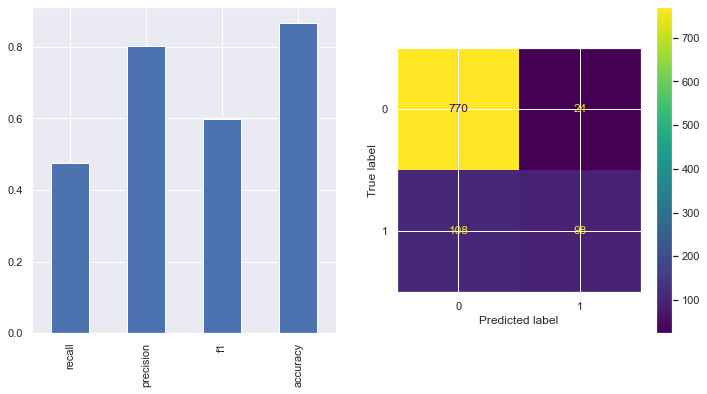

In [162]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

#  Metrics
recall_1 = recall_score(y_test, model_prediction)
precision_1 = precision_score(y_test, model_prediction)
f1_1 = f1_score(y_test, model_prediction)
accuracy_1 = accuracy_score(y_test, model_prediction)

#  Creating a Series
classification_scores = pd.Series([recall_1, precision_1, f1_1, accuracy_1], index=['recall', 'precision', 'f1', 'accuracy'])

#  Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

classification_scores.plot(kind='bar', ax=axes[0])
plot_confusion_matrix(X=X_test, y_true=y_test, estimator=pipeline_8, ax=axes[1])

From the results, it can be seen that the baseline model has a high accuracy of about 87\%. it also has a high precision at 80\% but a low recall at approximately 50\%. This implies that the model does a good job on identifying negative cases (0) but is poor at identifying positive cases (1) which is integral to our project objective. For the sake of this project, the baseline model is not ideal. 

### 9.2 Weighted Model

In [169]:
#  Testing model.

#  Predicting...
model_prediction_2 = pipeline_9.predict(X_test)
#  Predicting probability...
proba_preds_2 = pipeline_9.predict_proba(X_test)

#  Scoring...
test_score_2 = pipeline_9.score(X_test, y_test)
print(f'The model predicts the test results to {test_score_2.round(4)*100}% accuracy.')

The model predicts the test results to 72.3% accuracy.


#### 9.2.1 Results

In [171]:
#  Creating dataframe
results_2 = pd.DataFrame({'model_prediction': model_prediction_2, 'actual_class': y_test, 'probability_0': proba_preds_2[:,0].round(3), 'probability_1': proba_preds_2[:,1].round(3)}, index=X_test.index)
results_2.head()

,model_prediction,actual_class,probability_0,probability_1
RowNumber,,,,
9395,1,0,0.428,0.572
899,1,1,0.241,0.759
2399,0,0,0.571,0.429
5907,0,0,0.578,0.422
2344,0,0,0.775,0.225


#### 9.2.2 Metrics and Confusion Matrix Plots

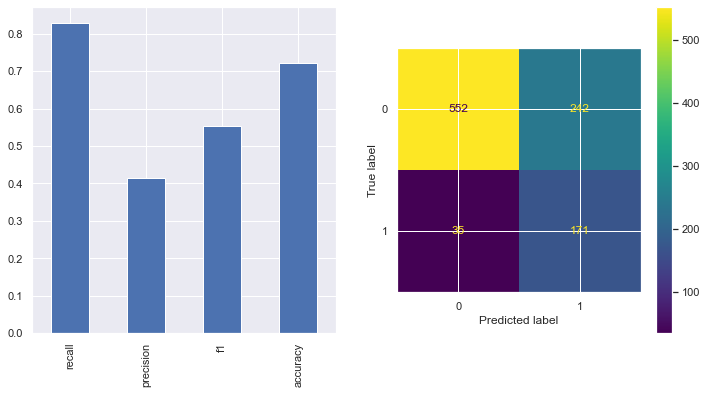

In [170]:
#  Deriving scores
recall_2 = recall_score(y_test, model_prediction_2)
precision_2 = precision_score(y_test, model_prediction_2)
f1_2 = f1_score(y_test, model_prediction_2)
accuracy_2 = accuracy_score(y_test, model_prediction_2)

#  Creating a series of scores
classification_scores_2 = pd.Series([recall_2, precision_2, f1_2, accuracy_2], index=['recall', 'precision', 'f1', 'accuracy'])

#  Plotting scores
figure, ax = plt.subplots(1, 2, figsize=(12,6))
classification_scores_2.plot(kind='bar', ax=ax[0])
plot_confusion_matrix(X=X_test, y_true=y_test, estimator=pipeline_9, ax=ax[1])

From the plots above, due to the class weights used, the weighted model has a lower accuracy compared to the baseline at approximately 72\%. Where the weighted model out-performs the baseline is in recall, with a recall of well above 80\%, the weighted model identified over 80\% of positive cases (1) which ties in nicely with the project objective. Precision does take a hit though at a value of slightly above 40\%.

## 10.0 Conclusion
The weighted model, domiciled in pipeline_9, does a good job at identifying most of the positive cases (churn) and therefore is the most suitable model. Although it will generate a sizeable number of false positives (false churn), all positive predictions should be selected for targeted email marketing and promos in a bid to retain the potential churn accounts.